In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd 

import random

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [20]:
import zipfile
from pathlib import Path

data_path = Path('MURA-v1.1/')

if not data_path.exists():
    data_path.mkdir()

with zipfile.ZipFile('MURA-v1.1.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print('Data extracted')

Data extracted


In [21]:
train_df = pd.read_csv(data_path/'train_image_paths.csv', header=None, names=['FilePath'])
valid_df = pd.read_csv(data_path/'valid_image_paths.csv', header=None, names=['FilePath'])
trainlabels_df = pd.read_csv(data_path/'train_labeled_studies.csv', header=None, names=['FilePath', 'Label'])
validlabels_df = pd.read_csv(data_path/'valid_labeled_studies.csv', header=None, names=['FilePath', 'Label'])

In [72]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        image = Image.open(img_name).convert('L')
        label = 1 if 'positive' in img_name else 0
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456], std=[0.224])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456], std=[0.224])
])



In [73]:
def get_study_data(study_type):
    train_studies = trainlabels_df[trainlabels_df['FilePath'].str.contains(study_type)]
    valid_studies = validlabels_df[validlabels_df['FilePath'].str.contains(study_type)]
    
    train_study_df = train_df[train_df['FilePath'].isin(train_studies['FilePath'])]
    valid_study_df = valid_df[valid_df['FilePath'].isin(valid_studies['FilePath'])]

    trainlabels_study_df = trainlabels_df[trainlabels_df['FilePath'].isin(train_studies['FilePath'])]
    validlabels_study_df = validlabels_df[validlabels_df['FilePath'].isin(valid_studies['FilePath'])]
    train_dataset = Dataset(train_study_df, transform=train_transform)
    valid_dataset = Dataset(valid_study_df, transform=valid_transform)
    
    return train_study_df, valid_study_df, trainlabels_study_df, validlabels_study_df

In [74]:
study_types = ['XR_WRIST', 'XR_HUMERUS', 'XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_SHOULDER']
study_train_df, study_valid_df, train_dataset, valid_dataset, train_dataloader, valid_dataloader = {}, {}, {}, {}, {}, {}

for study_type in study_types:
    study_train_df[study_type] = train_df[train_df['FilePath'].str.contains(study_type)]
    study_valid_df[study_type] = valid_df[valid_df['FilePath'].str.contains(study_type)]

    train_dataset[study_type] = Dataset(study_train_df[study_type], transform=train_transform)
    valid_dataset[study_type] = Dataset(study_valid_df[study_type], transform=valid_transform)

    train_dataloader[study_type] = DataLoader(train_dataset[study_type], batch_size=8, shuffle=True)
    valid_dataloader[study_type] = DataLoader(valid_dataset[study_type], batch_size=8, shuffle=False)

In [75]:
for study_type in study_types:
    print(f'{study_type}: {len(train_dataset[study_type])} training images and {len(valid_dataset[study_type])} validation images')
    for batch in train_dataloader[study_type]:
        print(batch[0].shape, batch[1].shape)
        break

XR_WRIST: 9752 training images and 659 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_HUMERUS: 1272 training images and 288 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_ELBOW: 4931 training images and 465 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_FINGER: 5106 training images and 461 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_FOREARM: 1825 training images and 301 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_HAND: 5543 training images and 460 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])
XR_SHOULDER: 8379 training images and 563 validation images
torch.Size([8, 1, 224, 224]) torch.Size([8])


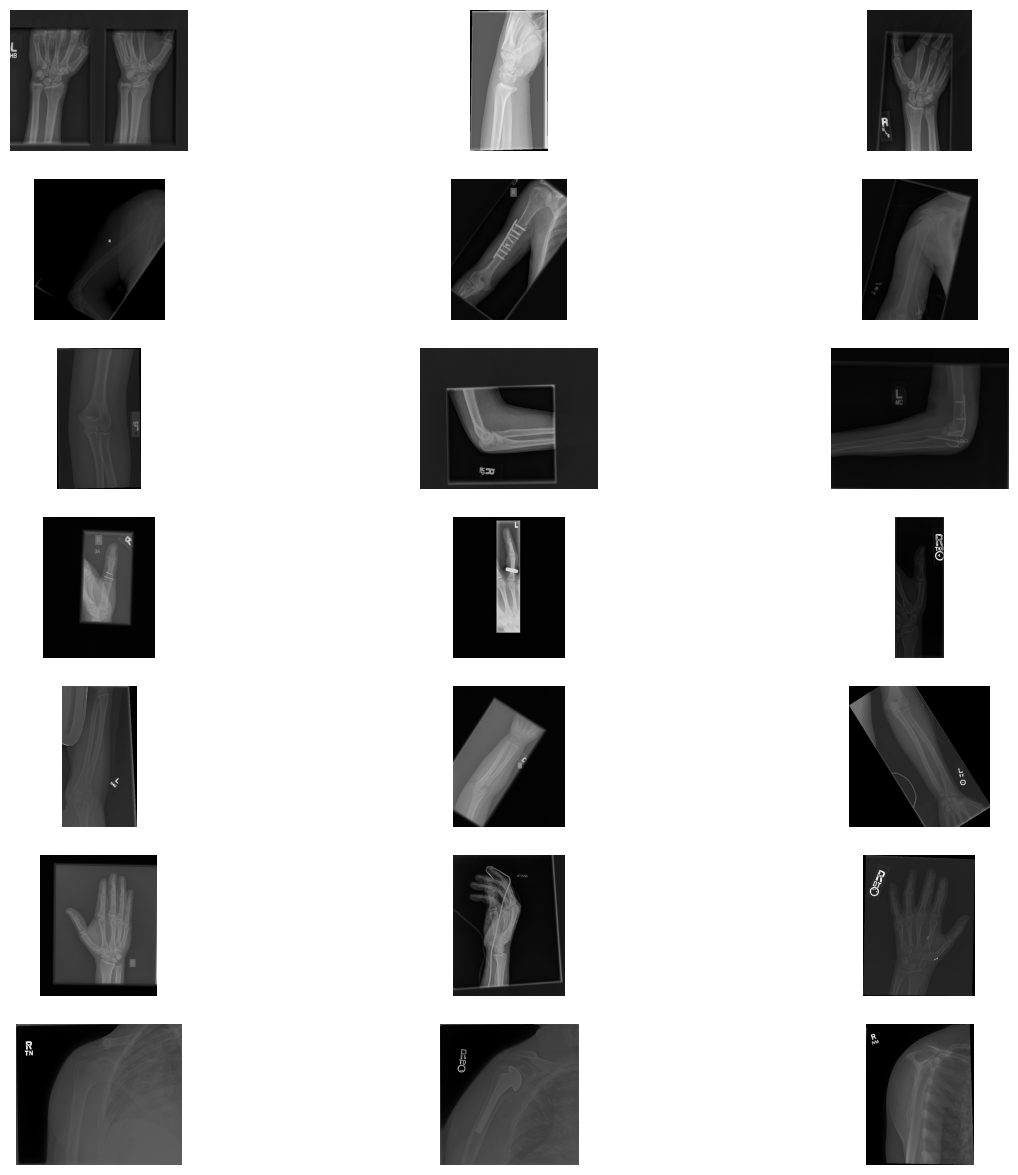

In [76]:
num_images = 3
fig, axs = plt.subplots(7, 3, figsize=(15, 15))
# Get random indices

for study_type in study_types:
    indices = random.sample(range(len(study_train_df[study_type])), num_images)
    for i, idx in enumerate(indices):
        img_path = study_train_df[study_type].iloc[idx]['FilePath']
        img = plt.imread(img_path)
        row = study_types.index(study_type)
        col = i
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].axis('off')

# Show the plot
plt.show()

In [88]:
from collections import OrderedDict




class DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(torch.cat(features, 1))
            features.append(new_features)
        return torch.cat(features, 1)

class Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, num_classes=2):
        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers=num_layers, num_input_features=num_features, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i+1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        self.fc = nn.Linear(1000, 1)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out


In [97]:
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained DenseNet121 model
model = models.densenet121(pretrained=True)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [93]:
def densenet121(pretrained=False, **kwargs):
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16), **kwargs)
    return model

model = densenet121()
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Change the output layer to have 2 classes
model.classifier = nn.Linear(model.classifier.in_features, 2)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [98]:

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 2

# Define the study types
study_types = ['XR_WRIST', 'XR_HUMERUS', 'XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_SHOULDER']

import torch.optim as optim

# Training loop
for study_type in study_types:
    # Get the dataloader for the current study type
    dataloader = train_dataloader[study_type]
    
    # Set the model to training mode
    model.train()
    
    # Iterate over the epochs
    for epoch in range(num_epochs):
        # Iterate over the batches
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Move the data to the device
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Print the loss every 100 batches
            if batch_idx % 100 == 0:
                print(f'Study Type: {study_type}, Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(dataloader)}, Loss: {loss.item()}')

Study Type: XR_WRIST, Epoch: 1/2, Batch: 0/1219, Loss: 8.074010848999023
Study Type: XR_WRIST, Epoch: 1/2, Batch: 100/1219, Loss: 0.6276944875717163
Study Type: XR_WRIST, Epoch: 1/2, Batch: 200/1219, Loss: 0.8710670471191406
Study Type: XR_WRIST, Epoch: 1/2, Batch: 300/1219, Loss: 0.678287923336029
Study Type: XR_WRIST, Epoch: 1/2, Batch: 400/1219, Loss: 0.9957469701766968
Study Type: XR_WRIST, Epoch: 1/2, Batch: 500/1219, Loss: 0.6462375521659851
Study Type: XR_WRIST, Epoch: 1/2, Batch: 600/1219, Loss: 0.9628432393074036
Study Type: XR_WRIST, Epoch: 1/2, Batch: 700/1219, Loss: 0.6697597503662109
Study Type: XR_WRIST, Epoch: 1/2, Batch: 800/1219, Loss: 0.7264957427978516
Study Type: XR_WRIST, Epoch: 1/2, Batch: 900/1219, Loss: 0.4915275275707245
Study Type: XR_WRIST, Epoch: 1/2, Batch: 1000/1219, Loss: 0.5482536554336548
Study Type: XR_WRIST, Epoch: 1/2, Batch: 1100/1219, Loss: 0.6155043840408325
Study Type: XR_WRIST, Epoch: 1/2, Batch: 1200/1219, Loss: 0.5363733172416687
Study Type: X

KeyboardInterrupt: 